# Investigation of representation drift through reduced model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from aux import r_tile, c_tile
from disp import set_font_size, set_color, fast_fig


# PARAMS
N = 1000
M = 200
N_MAX = 200
Q = .1
THT_S = 1
W_MIN = THT_S/50 + .0001
W_MAX = THT_S/4 + .0001

T_THT = 4
A_THT = 1

I_STD_0 = .375  # BASELINE NOISE
I_STD_1 = .8  # REACTIVATION NOISE

# PLASTICITY
A_P = .03
A_M = -.02
T_P = 3
T_M = 5
T_STDP_MAX = 5*max(T_P, T_M)

# STDP HELPER VARS
T_STDP_P = np.arange(T_STDP_MAX, dtype=float)
T_STDP_M = np.arange(-T_STDP_MAX, -1, dtype=float)
D_W_P_S = A_P*np.exp(-T_STDP_P/T_P)
D_W_M_S = A_M*np.exp(T_STDP_M/T_M)

Run smln

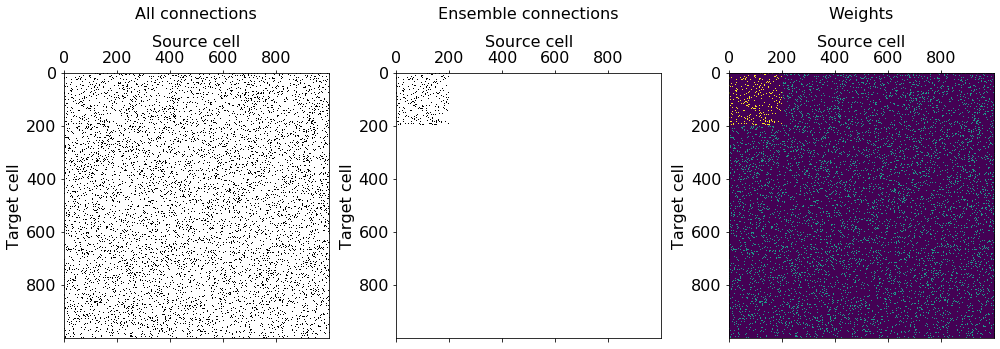

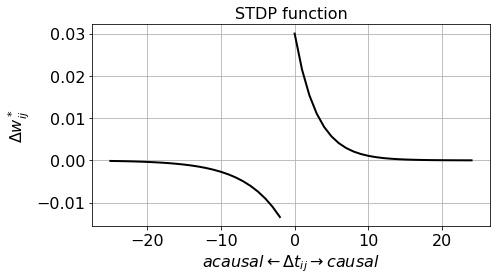

In [2]:
np.random.seed(0)

# set up weights
cxn = np.random.rand(N, N) < Q
w = np.zeros((N, N))
w[cxn] = W_MIN

# set up strongly connected ensemble
ens_mask = np.zeros(N, dtype=bool)
ens_mask[:M] = True
ens_cxn = cxn & np.outer(ens_mask, ens_mask)
w[ens_cxn] = W_MAX

# plot cxn matrices and weight matrices
fig, axs = plt.subplots(1, 3, figsize=(14, 5), tight_layout=True)
axs[0].spy(cxn)
axs[0].set_title('All connections\n\n')
axs[1].spy(ens_cxn)
axs[1].set_title('Ensemble connections\n\n')
axs[2].matshow(w, vmin=0, vmax=.15*W_MAX)
axs[2].set_title('Weights\n\n')

for ax in axs:
    ax.set_xlabel('Source cell')
    ax.set_ylabel('Target cell')
    ax.xaxis.set_label_position('top')
    set_font_size(ax, 16)

# plot STDP function
fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)
ax.plot(T_STDP_M, D_W_M_S, lw=2, c='k')
ax.plot(T_STDP_P, D_W_P_S, lw=2, c='k')
ax.set_xlabel(r'$acausal \leftarrow \Delta t_{ij} \rightarrow causal$')
ax.set_ylabel(r'$\Delta w^*_{ij}$')
ax.set_title('STDP function')

ax.grid()

set_font_size(ax, 16)

# run
np.random.seed(0)
N_T = 1000
T_REACT = np.arange(1, 10) * 100
T_SAVE_W = [1, 199, 399, 599, 799, 999]
BINS_W = np.linspace(W_MIN, W_MAX, 50)

vs = np.zeros((N_T, N))
thts = THT_S * np.ones((N_T, N))
spks = np.zeros((N_T, N), dtype=bool)
cts_w = np.zeros((N_T, len(BINS_W)-1), dtype=int)
ws = {}

for t in range(1, N_T):
    # get inputs
    ## external
    if t in T_REACT:
        i_ext = I_STD_1 * np.random.randn(N)
    else:
        i_ext = I_STD_0 * np.random.randn(N)
        
    ## recurrent
    i_rcr = w.dot(spks[t-1, :])
    
    ## total
    v = i_ext + i_rcr
    
    # thresholds
    tht = thts[t-1, :] - (1/T_THT)*(thts[t-1, :] - THT_S) + A_THT*spks[t-1, :]
    
    # mask N_MAX highest vs
    v_max = np.zeros(N, dtype=bool)
    v_max[np.argsort(v)[-N_MAX:]] = True
    
    # get spks
    spk = (v >= tht) & v_max  # spk if v above threshold and included in max vs
    
    # update w
    if True:
        # increase w where post spikes occurred
        mask_p = cxn & c_tile(spk, N)  # cxns w/ post spks
        d_w_p_s = r_tile(np.dot(D_W_P_S[::-1], spks[-T_STDP_MAX:, :]), N)  # \Delta w^*_+
        w[mask_p] += d_w_p_s[mask_p]*(W_MAX - w[mask_p])  # scale \Delta w^*_+ by dist to W_MAX
        
        # decrease w where pre spikes occurred
        mask_m = cxn * r_tile(spk, N)  # cxns w/ pre spks
        d_w_m_s = c_tile(np.dot(D_W_M_S, spks[-T_STDP_MAX:-1, :]), N)  # \Delta w^*_-
        w[mask_m] += d_w_m_s[mask_m]*(w[mask_m] - W_MIN)  # scale \Delta w^*_- by dist from W_MIN
        
    # save stuff
    ## dynamic vars
    vs[t, :] = v.copy()
    thts[t, :] = tht.copy()
    spks[t, :] = spk.copy()
    
    ## weight distribution
    cts_w[t, :] = np.histogram(w[cxn], BINS_W)[0]
    
    ## full weight matrix
    if t in T_SAVE_W:  # save full weight matrix
        ws[t] = w.copy()
          
t = np.arange(N_T)

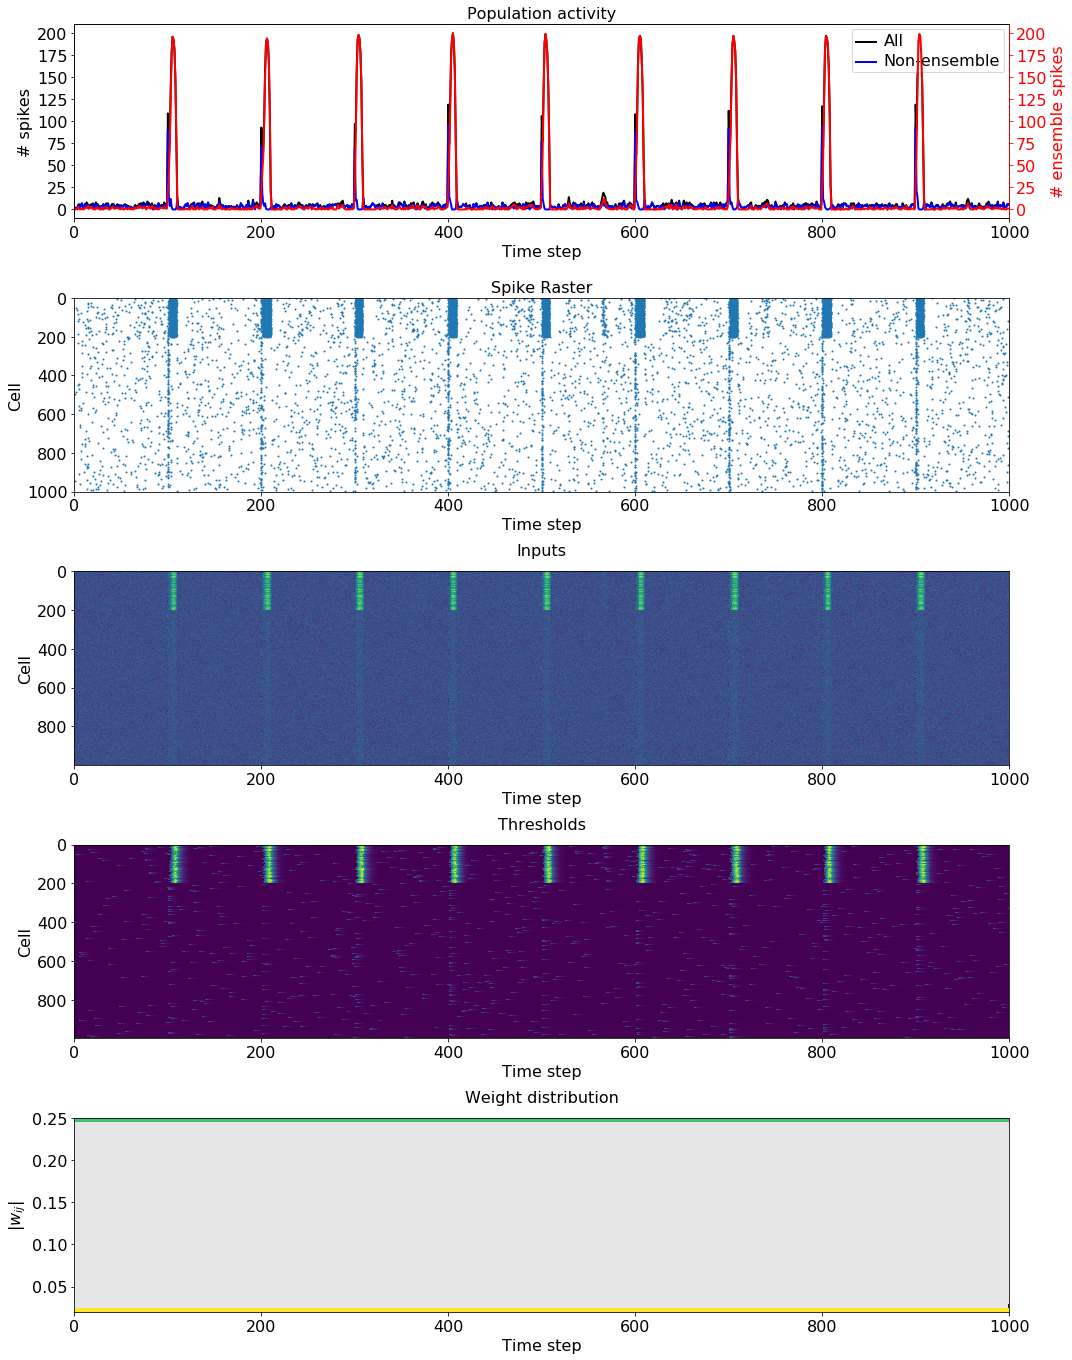

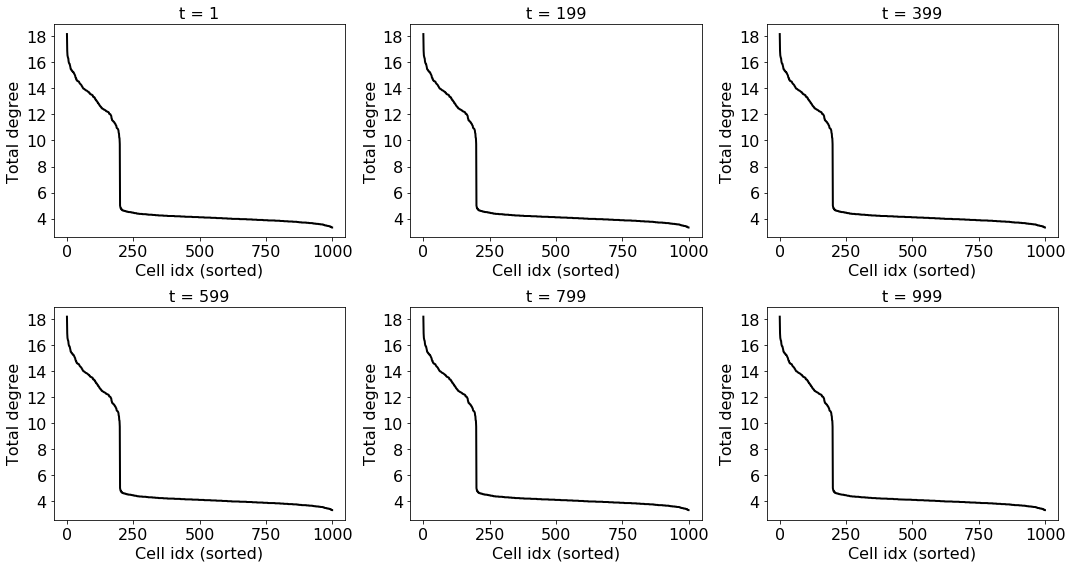

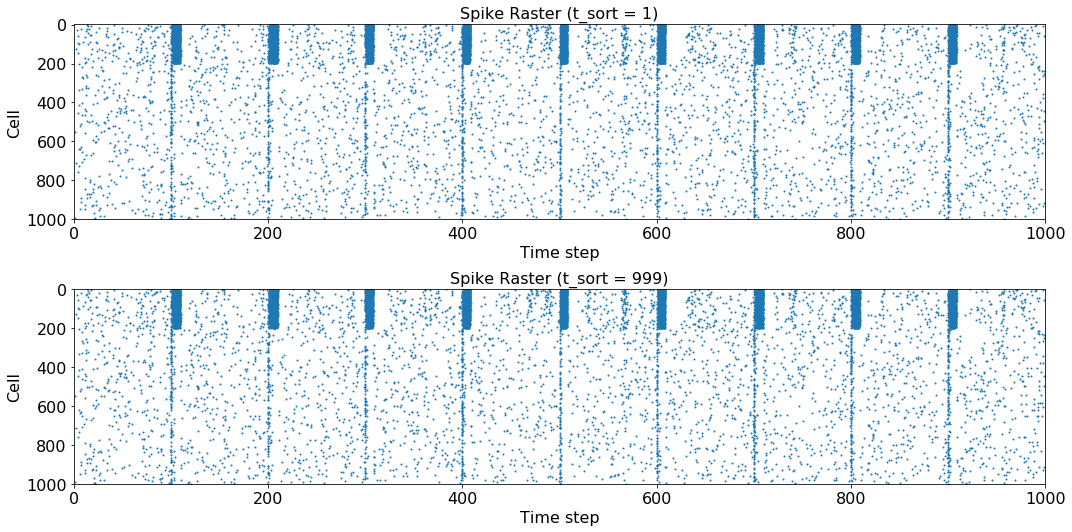

In [3]:
# plot dynamics and weight distribution
fig, axs = plt.subplots(5, 1, figsize=(15, 19), tight_layout=True)

## population activity
axs[0].plot(t, spks.sum(1), lw=2, color='k')
axs[0].plot(t, spks[:, ~ens_mask].sum(1), lw=2, color='b')
axs[0].set_xlim(0, N_T)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('# spikes')
axs[0].legend(['All', 'Non-ensemble'])
axs[0].set_title('Population activity')

ax_twin = axs[0].twinx()
ax_twin.plot(t, spks[:, ens_mask].sum(1), lw=2, color='r')
ax_twin.set_xlim(0, N_T)
ax_twin.set_ylabel('# ensemble spikes')

set_color(ax_twin, 'r')

## raster
axs[1].scatter(*np.nonzero(spks), s=1)
axs[1].set_xlim(0, N_T)
axs[1].set_ylim(N, -1)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Cell')
axs[1].set_title('Spike Raster')

## inputs
axs[2].matshow(vs.T, origin='upper', aspect='auto')
axs[2].xaxis.tick_bottom()
axs[2].set_xlim(0, N_T)
axs[2].set_xlabel('Time step')
axs[2].set_ylabel('Cell')
axs[2].set_title('Inputs')

## thresholds
axs[3].matshow(thts.T, origin='upper', aspect='auto')
axs[3].xaxis.tick_bottom()
axs[3].set_xlim(0, N_T)
axs[3].set_xlabel('Time step')
axs[3].set_ylabel('Cell')
axs[3].set_title('Thresholds')

## weight distr
axs[4].matshow(np.log(cts_w.T), origin='lower', aspect='auto', extent=[0, N_T, W_MIN, W_MAX])
axs[4].xaxis.tick_bottom()
axs[4].set_xlim(0, N_T)
axs[4].set_facecolor((.9, .9, .9))
axs[4].set_xlabel('Time step')
axs[4].set_ylabel(r'$|w_{ij}|$')
axs[4].set_title('Weight distribution')

for ax in list(axs) + [ax_twin]:
    set_font_size(ax, 16)
    
    
# plot degree vs sorted cell idx at chosen ts
fig, axs = fast_fig(len(T_SAVE_W), (4, 5))

sorted_k = {}

for ax, t_ in zip(axs, T_SAVE_W):

    # calc weighted degree
    k_out = ws[t_].sum(0)
    k_in = ws[t_].sum(1)
    k = k_out + k_in
    
    sorted_k[t_] = np.argsort(k)[::-1]
    
    ax.plot(sorted(k)[::-1], lw=2, color='k')
    ax.set_xticks([0, 250, 500, 750, 1000])
    ax.set_xlabel('Cell idx (sorted)')
    ax.set_ylabel('Total degree')
    ax.set_title('t = {}'.format(t_))

    set_font_size(ax, 16)
    
    
# plot rasters sorted by top-degree cells
T_SORT = [1, 999]

fig, axs = plt.subplots(len(T_SORT), 1, figsize=(15, 3.75*len(T_SORT)), tight_layout=True)

for ax, t_ in zip(axs, T_SORT):
    
    order = sorted_k[t_]
    spk_t, spk_idx_0 = np.nonzero(spks)
    spk_idx = np.argsort(order)[spk_idx_0]
    
    ax.scatter(spk_t, spk_idx, s=1)
    ax.set_xlim(0, N_T)
    ax.set_ylim(N, -1)
    ax.set_xlabel('Time step')
    ax.set_ylabel('Cell')
    ax.set_title('Spike Raster (t_sort = {})'.format(t_))

    set_font_size(ax, 16)